In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, optimizers, models_positive_const, blocks
reload(TN_utils)
reload(models_positive_const)
reload(blocks)

<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [3]:
input_tensors, output_tensors = TN_utils.load_blind(input_L=4, output_L=4, folder_name='in4out4')

[(0, 1), (1, 6), (6, 15)] [(0, 1), (1, 6), (6, 15)]
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 2)
(855000, 10)
(855000, 18)


In [4]:
rec_fodf = TN_utils.load_reconst_fodf(folder_name='in4out4')

In [5]:
rec_fodf.shape

(855000, 256)

In [24]:
train_input, train_output, test_input, test_output, input_coef =\
    TN_utils.pre_blind_pc(input_tensors, gt_vec=rec_fodf, N=10000)

In [25]:
[a.shape for a in train_input]

[(8000, 2, 1), (8000, 10, 1), (8000, 18, 1)]

In [26]:
train_output.shape

(8000, 256)

In [27]:
nn = models_positive_const.Rcn2layer_pc(
        j_input_list=[0, 2, 4], j_output_list=[2, 4], n_input_tensors_list=[1, 1, 1],
        n_hidden_tensors=100, func_key_list=['relu', 'linear'])

M_t.shape (256, 15)
pad.shape (256, 30)


In [ ]:
results = models_positive_const.compile(
        train_input, train_output, test_input, test_output,
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

[(0, 2), (2, 2), (2, 4), (4, 4)]
[(0, 4), (2, 2), (2, 4), (4, 4)]
[(0, 2), (2, 2), (2, 4), (4, 4)]
[(0, 4), (2, 2), (2, 4), (4, 4)]

In [12]:
batch_size = 99
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

0 0.247196282053 0.247192371967
10 0.247095005217 0.247097140472
20 0.247095631378 0.247093650801
30 0.247095583529 0.247090368424
40 0.247097656072 0.247093477737
Traceback (most recent call last):
  File "/home/matsui-k/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/matsui-k/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/home/matsui-k/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/matsui-k/anaconda/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/matsui-k/anaconda/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) 

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt



Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [16]:
pred_train2 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:100, np.newaxis, :] for tens in input_tensors],
                                            np.array(input_coef)[:, np.newaxis], 256)

(array([ 6144.,  7168.,  6144.,  1536.,  2560.,   512.,   512.,   768.,
            0.,   256.]),
 array([ 0.48701218,  0.49299632,  0.49898046,  0.5049646 ,  0.51094875,
         0.51693289,  0.52291703,  0.52890117,  0.53488532,  0.54086946,
         0.5468536 ]),
 <a list of 10 Patch objects>)

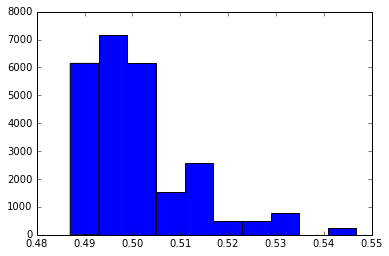

In [19]:
plt.hist(pred_train2.flatten())

In [21]:
# L=0しか効いてない, さいしょL=2, 4のあたいが小さいからそれでなんかなるんやろう
pred_train2[0]

array([ 0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50258762,
        0.50258762,  0.50258762,  0.50258762,  0.50258762,  0.50